<a href="https://colab.research.google.com/github/chvamshi/CNN-Models-on-CIFAR10-/blob/main/GoogLeNet/Googlenet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.models as models
import torchvision.utils

from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import time

# Use GPU if it is present
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [ ]:
batch_size = 1000

transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_data = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
test_data = datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)

# Split train data into training and valdation test sets
# https://stackoverflow.com/questions/57789645/torch-utils-data-random-split-is-not-splitting-the-data
train_size = int(0.8*len(train_data))
val_size = len(train_data) - train_size
train_data, val_data = torch.utils.data.random_split(train_data, [train_size, val_size])

train_loader = DataLoader(train_data,batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
class Train():
  def __init__(self, name, model, optimizer, loss_fn, train_loader, val_loader, epochs):
    self.name = name
    self.model = model
    self.optimizer = optimizer
    self.loss_fn = loss_fn
    self.train_loader = train_loader
    self.val_loader = val_loader

    self.epochs = epochs
    self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

  def train_val(self):
    self.best_val_loss = float('inf')
    
    self.train_losses = []
    self.train_accuracies = []

    self.val_losses = []
    self.val_accuracies = []

    for epoch in range(self.epochs):
      start_time = time.monotonic()

      self.train_loss, self.train_accuracy = self.train()
      self.val_loss, self.val_accuracy = self.evaluate()

      if self.val_loss < self.best_val_loss:
        best_val_loss = self.val_loss
        torch.save(self.model.state_dict(), '/content/drive/MyDrive/Colab Notebooks/Validation_state/'+self.name+'.pth')

      self.train_losses.append(self.train_loss)
      self.train_accuracies.append(self.train_accuracy)

      self.val_losses.append(self.val_loss)
      self.val_accuracies.append(self.val_accuracy)

      end_time = time.monotonic()

      epoch_mins, epoch_secs = self.epoch_time(start_time, end_time)

      print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
      print(f'\tTrain Loss: {self.train_loss:.3f} | Train Acc: {self.train_accuracy*100:.2f}%')
      print(f'\tVal.  Loss: {self.val_loss:.3f} | Val. Acc: {self.val_accuracy*100:.2f}%')
      print("="*75)

    self.save()

  def save(self):
    df = pd.DataFrame()

    df['Train Loss'] = self.train_losses
    df['Train Accracy'] = self.train_accuracies

    df['Validation Loss'] = self.val_losses
    df['Validation Accuracy'] = self.val_accuracies

    df.to_csv('/content/drive/MyDrive/Colab Notebooks/Saved_CSV/'+self.name+'.csv')
    
  def train(self):
    avg_losses = []
    avg_accuracies = []
    for i, data in enumerate(self.train_loader):
      inputs, labels = data[0].to(self.device), data[1].to(self.device)

      self.optimizer.zero_grad()

      y_pred = self.model(inputs)
      loss = self.loss_fn(y_pred, labels)

      loss.backward()
      self.optimizer.step()

      y_pred = y_pred.argmax(1)
      accuracy = accuracy_score(labels.cpu().detach().numpy(), y_pred.cpu().detach().numpy())
      
      avg_losses.append(loss.item())
      avg_accuracies.append(accuracy)

    avg_loss = sum(avg_losses) / len(avg_losses)
    avg_accuracy = sum(avg_accuracies) / len(avg_accuracies)
    
    return avg_loss, avg_accuracy

  def evaluate(self):
    avg_losses = []
    avg_accuracies = []

    with torch.no_grad():
      for i, data in enumerate(val_loader):
        inputs, labels = data[0].to(device), data[1].to(device)

        y_pred = self.model(inputs)
        loss = self.loss_fn(y_pred, labels)
        accuracy = accuracy_score(labels.cpu().detach().numpy(), y_pred.argmax(1).cpu().detach().numpy())

        avg_losses.append(loss.item())
        avg_accuracies.append(accuracy)

    avg_loss = sum(avg_losses) / len(avg_losses)
    avg_accuracy = sum(avg_accuracies) / len(avg_accuracies)

    return avg_loss, avg_accuracy

  def test(self, best_model, test_loader):
    avg_losses = []
    avg_accuracies = []

    with torch.no_grad():
      for i, data in enumerate(test_loader):
        inputs, labels = data[0].to(device), data[1].to(device)

        y_pred = best_model(inputs)
        loss = self.loss_fn(y_pred, labels)
        accuracy = accuracy_score(labels.cpu().detach().numpy(), y_pred.argmax(1).cpu().detach().numpy())

        avg_losses.append(loss.item())
        avg_accuracies.append(accuracy)

    avg_loss = sum(avg_losses) / len(avg_losses)
    avg_accuracy = sum(avg_accuracies) / len(avg_accuracies)

    return avg_loss, avg_accuracy

  def epoch_time(self, start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

  def loss_plot(self):
    Epochs = [i for i in range(self.epochs)]
    plt.plot(Epochs, self.train_losses,'r', label="Training loss")
    plt.plot(Epochs, self.val_losses,'g', label="Validation loss")
    plt.legend()
    plt.show()

  def accuracy_plot(self):
    Epochs = [i for i in range(self.epochs)]
    multiplied_list = [element * 100 for element in self.train_accuracies]
    multiplied_list1 = [element * 100 for element in self.val_accuracies]
    plt.plot(Epochs, multiplied_list,'r', label="Training Accuracy")
    plt.plot(Epochs, multiplied_list1,'g', label="Validation Accuracy")
    plt.legend()
    plt.show()

  def save_model(self):
    PATH = '/content/drive/MyDrive/Colab Notebooks/'+self.name+'_cifar10.pth'
    torch.save(self.model.state_dict(), PATH)

In [ ]:
model = models.googlenet(pretrained=True)
# Change the final layer to no. of output dimensions
model.fc = nn.Linear(1024, 10)
# Freeze all the layers weights to speed up the learning
# for parameter in model.parameters():
#   parameter.requires_grad = False
# # Unfreeze the last layer 
# model.fc.requires_grad_ = True

lr = 5e-4
epochs = 50
optimizer = optim.Adam(params = model.parameters(),lr=lr)
loss_fn = nn.CrossEntropyLoss()

model.to(device)

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [ ]:
epochs = 50
googlenet = Train(name="googlenet",model=model,optimizer=optimizer,loss_fn=loss_fn,train_loader=train_loader,val_loader=val_loader,epochs=epochs)
googlenet.train_val()

Epoch: 01 | Epoch Time: 0m 9s
	Train Loss: 1.358 | Train Acc: 53.21%
	Val.  Loss: 0.864 | Val. Acc: 69.95%
Epoch: 02 | Epoch Time: 0m 9s
	Train Loss: 0.660 | Train Acc: 77.13%
	Val.  Loss: 0.732 | Val. Acc: 74.68%
Epoch: 03 | Epoch Time: 0m 9s
	Train Loss: 0.387 | Train Acc: 86.91%
	Val.  Loss: 0.768 | Val. Acc: 75.53%
Epoch: 04 | Epoch Time: 0m 9s
	Train Loss: 0.204 | Train Acc: 93.41%
	Val.  Loss: 0.882 | Val. Acc: 75.65%
Epoch: 05 | Epoch Time: 0m 9s
	Train Loss: 0.121 | Train Acc: 96.07%
	Val.  Loss: 0.986 | Val. Acc: 76.06%
Epoch: 06 | Epoch Time: 0m 9s
	Train Loss: 0.099 | Train Acc: 96.74%
	Val.  Loss: 1.069 | Val. Acc: 75.59%
Epoch: 07 | Epoch Time: 0m 9s
	Train Loss: 0.093 | Train Acc: 96.94%
	Val.  Loss: 1.061 | Val. Acc: 76.86%
Epoch: 08 | Epoch Time: 0m 9s
	Train Loss: 0.070 | Train Acc: 97.65%
	Val.  Loss: 1.104 | Val. Acc: 76.54%
Epoch: 09 | Epoch Time: 0m 9s
	Train Loss: 0.055 | Train Acc: 98.18%
	Val.  Loss: 1.128 | Val. Acc: 77.51%
Epoch: 10 | Epoch Time: 0m 10s
	Train

In [ ]:
googlenet.save_model()

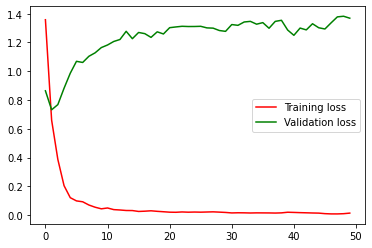

In [ ]:
googlenet.loss_plot()

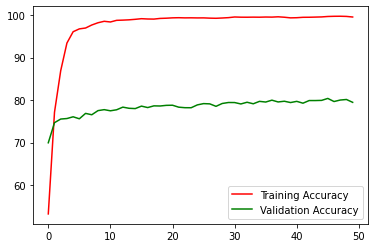

In [ ]:
googlenet.accuracy_plot()

In [ ]:
best_model = models.googlenet(pretrained=True)
# Change the final layer to no. of output dimensions
best_model.fc = nn.Linear(1024, 10)
best_model.to(device)
best_model.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/Validation_state/googlenet.pth'))

test_loss, test_accuracy = googlenet.test(best_model, test_loader)
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_accuracy*100:.2f}%')

Test Loss: 1.408 | Test Acc: 79.53%


In [ ]:
def get_predictions(model, iterator):

    model.eval()

    images = []
    labels = []
    probs = []

    with torch.no_grad():

        for (x, y) in iterator:

            x = x.to(device)

            y_pred = model(x)

            y_prob = F.softmax(y_pred, dim = -1)
            top_pred = y_prob.argmax(1, keepdim = True)

            images.append(x.cpu())
            labels.append(y.cpu())
            probs.append(y_prob.cpu())

    images = torch.cat(images, dim = 0)
    labels = torch.cat(labels, dim = 0)
    probs = torch.cat(probs, dim = 0)

    return images, labels, probs

def plot_confusion_matrix(labels, pred_labels, classes):
    
    fig = plt.figure(figsize = (10, 10));
    ax = fig.add_subplot(1, 1, 1);
    cm = confusion_matrix(labels, pred_labels);
    cm = ConfusionMatrixDisplay(cm, display_labels = classes);
    cm.plot(values_format = 'd', cmap = 'Blues', ax = ax)
    plt.xticks(rotation = 20)

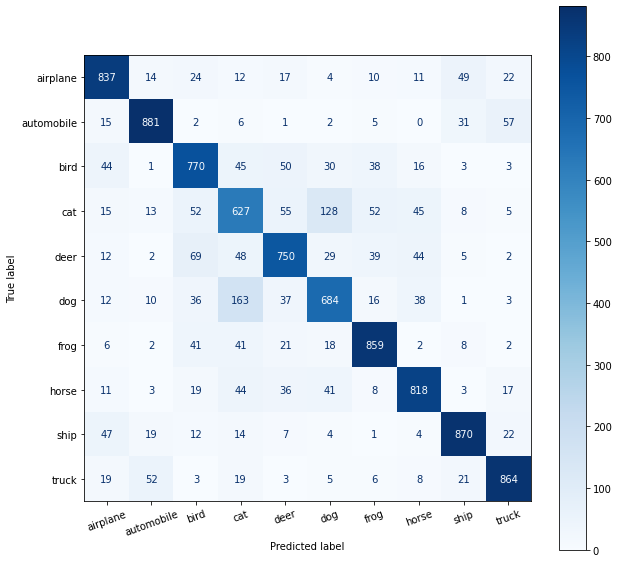

In [ ]:
images, labels, probs = get_predictions(best_model, test_loader)
pred_labels = torch.argmax(probs, 1)
classes = test_data.classes
plot_confusion_matrix(labels, pred_labels, classes)

precision:- OF all the images that have been classified for that class, how many did we correctly classify <br>
recall : - of all the images that have been truly classified for that class, how many did we label for that class

In [ ]:
print(f'{classification_report(labels, pred_labels)}')

              precision    recall  f1-score   support

           0       0.82      0.84      0.83      1000
           1       0.88      0.88      0.88      1000
           2       0.75      0.77      0.76      1000
           3       0.62      0.63      0.62      1000
           4       0.77      0.75      0.76      1000
           5       0.72      0.68      0.70      1000
           6       0.83      0.86      0.84      1000
           7       0.83      0.82      0.82      1000
           8       0.87      0.87      0.87      1000
           9       0.87      0.86      0.87      1000

    accuracy                           0.80     10000
   macro avg       0.80      0.80      0.80     10000
weighted avg       0.80      0.80      0.80     10000

